In [1]:
# imports
import copy
from matplotlib import pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline


In [2]:
def argmax_tensor(t: torch.Tensor):
	return torch.argmax(t).item()


In [3]:
from torch.utils.data import TensorDataset, DataLoader
def read_32bit_uint(file):
	return int.from_bytes(file.read(4), "big", signed=False)

def read_byte_uint(file):
	return int.from_bytes(file.read(1), "big", signed=False)

# load MNIST data
def load_mnist(images_filename, labels_filename):
	images = list()
	rows = 0
	cols = 0
	with open(images_filename, 'rb') as file:
		magic_number = read_32bit_uint(file)
		number_images = read_32bit_uint(file)
		rows = read_32bit_uint(file)
		cols = read_32bit_uint(file)
		for image_index in range(number_images):
			image = torch.empty([rows, cols])
			for row_index in range(rows):
				for col_index in range(cols):
					image[row_index, col_index] = 255 - read_byte_uint(file)
			images.append(image)
	
	labels = list()
	label_options = set()
	with open(labels_filename, 'rb') as file:
		magic_number = read_32bit_uint(file)
		number_labels = read_32bit_uint(file)
		for label_index in range(number_labels):
			this_label = read_byte_uint(file)
			labels.append(this_label)
			label_options.add(this_label)
	label_options = list(label_options)
	
	return [(images[i], labels[i]) for i in range(len(images))], (rows, cols), label_options
	
time_load_start = time.time()
mnist_training, training_dimensions, training_label_options = load_mnist("mnist/training/train-images.idx3-ubyte", "mnist/training/train-labels.idx1-ubyte")
mnist_test, test_dimensions, test_label_options = load_mnist("mnist/test/t10k-images.idx3-ubyte", "mnist/test/t10k-labels.idx1-ubyte")
time_load_end = time.time()
print("Loaded MNIST data in", time_load_end - time_load_start, "seconds")

# construct a dictionary from label value to index in training_label_options
label_to_index = dict()
for index, label_value in enumerate(training_label_options):
	label_to_index[label_value] = index


Loaded MNIST data in 1029.2017602920532 seconds


In [26]:
# verify data
if training_dimensions != test_dimensions:
	print("WARNING: training data dimensions and test data dimensions do not match!")
	print("training dimensions:", training_dimensions)
	print("test dimensions:", test_dimensions)
else:
	print("input dimensions:", training_dimensions)
if training_label_options != test_label_options:
	print("WARNING: training data labels and test data labels do not match!")
	print("training labels:", training_label_options)
	print("test labels:", test_label_options)
else:
	print("available labels:", test_label_options)


input dimensions: (28, 28)
available labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# of training data: 60000
# of testing data: 10000


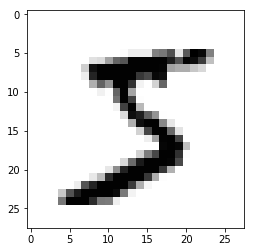

In [27]:
# show one of the images to test if we've loaded MNIST data
test_image, test_label = mnist_training[0]
# convert the image to floats
test_image = test_image.float()
plt.imshow(test_image, cmap="gray", vmin=0, vmax=255)
# show how many data we have
print("# of training data:", len(mnist_training))
print("# of testing data:", len(mnist_test))


In [28]:
# re-shape the images into vectors

def label_to_vector(label: int):
	target_vector = torch.zeros([len(training_label_options)])
	target_vector[label_to_index[label]] = 1.0
	return target_vector

mnist_training_vectors = [(image.view([-1]), label_to_vector(label)) for image, label in mnist_training]
mnist_test_vectors = [(image.view([-1]), label_to_vector(label)) for image, label in mnist_test]


In [53]:
# define my generic simple net class
class SimpleNet(nn.Module):
	def __init__(self, input_size, hidden_layer_size, output_size):
		super(SimpleNet, self).__init__()
		# save the meta-parameters
		self.input_size = input_size
		self.hidden_layer_size = hidden_layer_size
		self.output_size = output_size
		self.hidden_layers_count = 2
		# create layer transitions
		self.layer_input_to_1 = nn.Linear(self.input_size, self.hidden_layer_size, True).cuda()
		self.layer_1_to_2 = nn.Linear(self.hidden_layer_size, self.hidden_layer_size, True).cuda()
		self.layer_2_to_output = nn.Linear(self.hidden_layer_size, self.output_size, True).cuda()
 
	def forward(self, x: torch.Tensor):
		x = x.cuda()
		x = torch.sigmoid(self.layer_input_to_1(x))
		x = torch.sigmoid(self.layer_1_to_2(x))
		x = torch.sigmoid(self.layer_2_to_output(x))
		return x
	
def forward_grayscale_image(net, image: torch.Tensor):
	x = image.view([-1]).cuda()
	return net.forward(x)

# function to test accuracy on a dataset
def calculate_accuracy(net, test_data):
	total_count = len(test_data)
	if total_count == 0:
		print("no data to test")
		return 0
	correct = 0
	for input_image, correct_output in test_data:
		correct_label = argmax_tensor(correct_output)
		actual_output = forward_grayscale_image(net, input_image)
		actual_label = training_label_options[argmax_tensor(actual_output)]
		if actual_label == correct_label:
			correct += 1
	return correct / total_count


In [54]:
# construct an instance
linear_input_size = 1
for dimension_size in training_dimensions:
	linear_input_size *= dimension_size
net_MNIST = SimpleNet(linear_input_size, 30, len(training_label_options))

print(net_MNIST)
params = list(net_MNIST.parameters())
print(len(params))


SimpleNet(
  (layer_input_to_1): Linear(in_features=784, out_features=30, bias=True)
  (layer_1_to_2): Linear(in_features=30, out_features=30, bias=True)
  (layer_2_to_output): Linear(in_features=30, out_features=10, bias=True)
)
6


In [62]:
# train the net

def training_pairs_to_tensors(list_of_pairs):
	first = torch.stack([t[0] for t in list_of_pairs])
	second = torch.stack([t[1] for t in list_of_pairs])
	return first, second

def create_batches(training_data, minimum_batch_size):
	data_count = len(training_data)
	number_of_batches = data_count // minimum_batch_size
	batches = [list() for i in range(number_of_batches)]
	unused_datum_indices = set(range(data_count))
	batch_index = 0
	while len(unused_datum_indices) > 0:
		chosen_index = unused_datum_indices.pop()
		batches[batch_index].append(training_data[chosen_index])
		batch_index += 1
		batch_index %= number_of_batches
	return batches

def train(model, full_training_data, learning_rate, batch_size):
	# split training data into training and verification
	split_index = int(len(full_training_data) * 0.9)
	training_data = full_training_data[:split_index]
	verification_data = full_training_data[split_index:]
	# make a place to record accuracy
	domain = list()
	accuracy_values = list()
	# ensures the next loop runs at least once
	verification_accuracy_previous = -1.0
	verification_accuracy_current = calculate_accuracy(model, verification_data)
	# save accuracy
	time_training_start = time.time()
	domain.append(time.time() - time_training_start)
	accuracy_values.append(verification_accuracy_current)
	# make our loss function and optimizer
	criterion = nn.MSELoss(reduction="sum")
	optimizer = optim.SGD(model.parameters(), lr=learning_rate)
	# train until the verification accuracy goes down by more than a specified margin
	epochs = 0
	while epochs < 30 or verification_accuracy_current - verification_accuracy_previous > -0.005:
		epochs += 1
		# make batches
		batches = create_batches(training_data, batch_size)
		# use the batches for gradient descent
		first_batch = True
		for batch in batches:
			# unzip the training data into two huge tensors
			batch_inputs_stacked, batch_outputs_stacked = training_pairs_to_tensors(batch)
			batch_inputs_stacked = batch_inputs_stacked.cuda()
			batch_outputs_stacked = batch_outputs_stacked.cuda()
			# put the batch through
			output = model(batch_inputs_stacked)
			loss = criterion(output, batch_outputs_stacked)
			optimizer.zero_grad()
			loss.backward()
			# if first_batch:
			# 	print("grad:", list(model.parameters())[0].grad)
			optimizer.step()
			first_batch = False
		verification_accuracy_previous = verification_accuracy_current
		verification_accuracy_current = calculate_accuracy(model, verification_data)
		# save accuracy
		domain.append(time.time() - time_training_start)
		accuracy_values.append(verification_accuracy_current)
		print("verification_accuracy_current:", verification_accuracy_current)
	# plot the accuracy over time
	plt.plot(domain, accuracy_values)
	plt.xlabel("time elapsed (s)")
	plt.ylabel("accuracy")
	plt.show()

LEARNING_RATE = 1e-2
train(net_MNIST, mnist_training_vectors, LEARNING_RATE, 100)


verification_accuracy_current: 0.1
verification_accuracy_current: 0.1
verification_accuracy_current: 0.1
verification_accuracy_current: 0.1
verification_accuracy_current: 0.09916666666666667
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975
verification_accuracy_current: 0.0975


KeyboardInterrupt: 

In [ ]:
# run some tests
final_accuracy = calculate_accuracy(net_MNIST, mnist_test_vectors)
print("final accuracy:", final_accuracy)

